# Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.

In [1]:
import time
import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import spatial
import matplotlib.pyplot as plt
import random

nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
corpus = brown.sents()

In [4]:
stop_words = set(stopwords.words('english'))
corpus = [[word for word in sent if word.lower() not in stop_words] for sent in corpus]

# Remove punctuation from corpus
from string import punctuation
corpus = [[word for word in sent if word not in punctuation] for sent in corpus]

# Remove empty sentences
corpus = [sent for sent in corpus if len(sent) > 0]

# Remove sentences with less than 5 words
corpus = [sent for sent in corpus if len(sent) >= 5]

# Remove sentences with more than 20 words
corpus = [sent for sent in corpus if len(sent) <= 20]

# Remove rare words
from collections import Counter
word_freq = Counter([word for sent in corpus for word in sent])
corpus = [[word for word in sent if word_freq[word] > 5] for sent in corpus]

In [5]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['violent',
 'thinking',
 'extreme',
 'rough',
 'reforms',
 'connected',
 'forgiveness',
 'techniques',
 'Mays',
 'prostitution',
 'Manhattan',
 'grounded',
 'Gun',
 'confusion',
 'blockade',
 'provisions',
 'fearful',
 'reasoning',
 'quit',
 'art',
 'existing',
 'devised',
 'acting',
 'tenants',
 'underlying',
 'gloves',
 'Rourke',
 'Aunt',
 'bites',
 'poverty',
 'Heiser',
 'teaches',
 'conceivable',
 'innocent',
 'conveyed',
 'slaves',
 'confirm',
 'zero',
 'warm',
 'discover',
 'winning',
 'promptly',
 'hill',
 'Joseph',
 'Jesus',
 'pitch',
 'dishes',
 'wastes',
 'crying',
 'eliminating',
 'underwater',
 'degree',
 'bloc',
 'Assembly',
 'twist',
 'slips',
 'guarantee',
 'articles',
 'screws',
 'right',
 'interpreter',
 'remark',
 'Diane',
 'became',
 'Steichen',
 'murders',
 'Autocoder',
 'shower',
 'vitamins',
 'plate',
 'world-wide',
 'charming',
 'hat',
 'maneuvers',
 'Strasbourg',
 'endurance',
 'McKinley',
 'letters',
 'corruption',
 'snapped',
 'passages',
 'percent',
 'Snow',

In [6]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'violent': 0, 'thinking': 1, 'extreme': 2, 'rough': 3, 'reforms': 4, 'connected': 5, 'forgiveness': 6, 'techniques': 7, 'Mays': 8, 'prostitution': 9, 'Manhattan': 10, 'grounded': 11, 'Gun': 12, 'confusion': 13, 'blockade': 14, 'provisions': 15, 'fearful': 16, 'reasoning': 17, 'quit': 18, 'art': 19, 'existing': 20, 'devised': 21, 'acting': 22, 'tenants': 23, 'underlying': 24, 'gloves': 25, 'Rourke': 26, 'Aunt': 27, 'bites': 28, 'poverty': 29, 'Heiser': 30, 'teaches': 31, 'conceivable': 32, 'innocent': 33, 'conveyed': 34, 'slaves': 35, 'confirm': 36, 'zero': 37, 'warm': 38, 'discover': 39, 'winning': 40, 'promptly': 41, 'hill': 42, 'Joseph': 43, 'Jesus': 44, 'pitch': 45, 'dishes': 46, 'wastes': 47, 'crying': 48, 'eliminating': 49, 'underwater': 50, 'degree': 51, 'bloc': 52, 'Assembly': 53, 'twist': 54, 'slips': 55, 'guarantee': 56, 'articles': 57, 'screws': 58, 'right': 59, 'interpreter': 60, 'remark': 61, 'Diane': 62, 'became': 63, 'Steichen': 64, 'murders': 65, 'Autocoder': 66, 'showe

In [7]:
#vocab size
voc_size = len(vocab)
print(voc_size)

10582


In [8]:
#append UNK
vocab.append('<UNK>')

In [9]:
vocab

['violent',
 'thinking',
 'extreme',
 'rough',
 'reforms',
 'connected',
 'forgiveness',
 'techniques',
 'Mays',
 'prostitution',
 'Manhattan',
 'grounded',
 'Gun',
 'confusion',
 'blockade',
 'provisions',
 'fearful',
 'reasoning',
 'quit',
 'art',
 'existing',
 'devised',
 'acting',
 'tenants',
 'underlying',
 'gloves',
 'Rourke',
 'Aunt',
 'bites',
 'poverty',
 'Heiser',
 'teaches',
 'conceivable',
 'innocent',
 'conveyed',
 'slaves',
 'confirm',
 'zero',
 'warm',
 'discover',
 'winning',
 'promptly',
 'hill',
 'Joseph',
 'Jesus',
 'pitch',
 'dishes',
 'wastes',
 'crying',
 'eliminating',
 'underwater',
 'degree',
 'bloc',
 'Assembly',
 'twist',
 'slips',
 'guarantee',
 'articles',
 'screws',
 'right',
 'interpreter',
 'remark',
 'Diane',
 'became',
 'Steichen',
 'murders',
 'Autocoder',
 'shower',
 'vitamins',
 'plate',
 'world-wide',
 'charming',
 'hat',
 'maneuvers',
 'Strasbourg',
 'endurance',
 'McKinley',
 'letters',
 'corruption',
 'snapped',
 'passages',
 'percent',
 'Snow',

In [10]:
word2index['<UNK>'] = 0

In [11]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [12]:
for c in corpus:
    print(c)

['Fulton', 'County', 'Grand', 'said', 'Friday', 'investigation', 'recent', 'primary', 'election', 'produced', '``', 'evidence', "''", 'took', 'place']
['jury', 'said', 'City', 'Executive', 'Committee', 'over-all', 'charge', 'election', '``', 'deserves', 'praise', 'thanks', 'City', 'Atlanta', "''", 'manner', 'election', 'conducted']
['``', 'relative', 'handful', 'reports', 'received', "''", 'jury', 'said', '``', 'considering', 'widespread', 'interest', 'election', 'number', 'voters', 'size', 'city', "''"]
['jury', 'said', 'find', 'many', "Georgia's", 'registration', 'election', 'laws', '``', 'inadequate', 'often', 'ambiguous', "''"]
['recommended', 'Fulton', 'legislators', 'act', '``', 'laws', 'studied', 'revised', 'end', 'improving', "''"]
['However', 'jury', 'said', 'believes', '``', 'two', 'offices', 'combined', 'achieve', 'greater', 'efficiency', 'reduce', 'cost', 'administration', "''"]
['City', 'Department', 'jury', 'said', '``', 'lacking', 'experienced', 'clerical', 'personnel', 

In [13]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    # Make skip gram of dynamic window size with default size of 2
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - j]] for j in range(1, window_size + 1) if i - j > 0] + [word2index[sent[i + j]] for j in range(1, window_size + 1) if i + j < len(sent)]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

In [14]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[9964]
 [7474]]
Target:  [[9486]
 [9819]]


In [15]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

In [16]:
Z = 0.001

In [17]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [18]:
word_count[',']

0

In [19]:
num_total_words

356098

In [20]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [21]:
Counter(unigram_table)

Counter({'``': 45,
         "''": 45,
         'one': 22,
         '--': 22,
         'would': 20,
         'said': 17,
         'time': 14,
         'could': 14,
         'two': 12,
         'may': 12,
         'like': 11,
         'man': 11,
         'first': 11,
         'must': 10,
         'new': 10,
         'also': 10,
         'back': 10,
         'Af': 10,
         'made': 10,
         'many': 9,
         'even': 9,
         'way': 9,
         'years': 9,
         'much': 9,
         'people': 8,
         'make': 8,
         'well': 8,
         'Mr.': 8,
         'see': 8,
         'work': 8,
         'little': 8,
         'still': 8,
         'get': 8,
         'good': 8,
         'might': 7,
         'year': 7,
         'last': 7,
         'long': 7,
         'world': 7,
         'know': 7,
         'never': 7,
         'used': 7,
         'us': 7,
         'life': 7,
         'men': 7,
         'came': 7,
         'right': 6,
         'great': 6,
         'three': 6,
      

### Negative Sampling

In [22]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

In [23]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [24]:
target_batch.shape

torch.Size([2, 1])

In [25]:
input_batch

tensor([[9964.],
        [7474.]])

In [26]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

#{'grapes': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'ice': 4, 'orange': 5, 'dog': 6, 'monkey': 7, 'conda': 8, 'fruit': 9, 'banana': 10}

tensor([[9346, 7080, 7291],
        [2480, 1118, 1456]])

In [27]:
target_batch[1]

tensor([9819])

In [28]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [29]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
import time
start = time.time()

# Training
num_epochs = 1000
for epoch in range(num_epochs):

    input_batch, target_batch = random_batch(batch_size, corpus)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    epoch_mins, epoch_secs = epoch_time(start, time.time())
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 100 | cost: 10.553164 | time: 3m 27s
Epoch: 200 | cost: 9.707071 | time: 6m 47s
Epoch: 300 | cost: 8.628217 | time: 10m 13s
Epoch: 400 | cost: 8.900997 | time: 13m 47s
Epoch: 500 | cost: 7.811802 | time: 17m 8s
Epoch: 600 | cost: 7.579991 | time: 20m 30s
Epoch: 700 | cost: 6.802591 | time: 23m 52s
Epoch: 800 | cost: 10.075821 | time: 27m 25s
Epoch: 900 | cost: 8.458256 | time: 30m 53s
Epoch: 1000 | cost: 8.591949 | time: 34m 46s


In [32]:
#list of vocabs
vocab[:10]

['violent',
 'thinking',
 'extreme',
 'rough',
 'reforms',
 'connected',
 'forgiveness',
 'techniques',
 'Mays',
 'prostitution']

In [33]:
word = vocab[0]

In [34]:
#numericalization
id = word2index[word]
id

0

In [35]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [36]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.9538, -1.5633]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.6667,  1.9703]], grad_fn=<EmbeddingBackward0>))

In [37]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.2035, grad_fn=<SelectBackward0>)

In [38]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

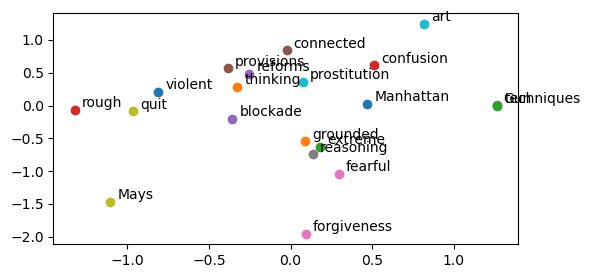

In [39]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [40]:
vocab

['violent',
 'thinking',
 'extreme',
 'rough',
 'reforms',
 'connected',
 'forgiveness',
 'techniques',
 'Mays',
 'prostitution',
 'Manhattan',
 'grounded',
 'Gun',
 'confusion',
 'blockade',
 'provisions',
 'fearful',
 'reasoning',
 'quit',
 'art',
 'existing',
 'devised',
 'acting',
 'tenants',
 'underlying',
 'gloves',
 'Rourke',
 'Aunt',
 'bites',
 'poverty',
 'Heiser',
 'teaches',
 'conceivable',
 'innocent',
 'conveyed',
 'slaves',
 'confirm',
 'zero',
 'warm',
 'discover',
 'winning',
 'promptly',
 'hill',
 'Joseph',
 'Jesus',
 'pitch',
 'dishes',
 'wastes',
 'crying',
 'eliminating',
 'underwater',
 'degree',
 'bloc',
 'Assembly',
 'twist',
 'slips',
 'guarantee',
 'articles',
 'screws',
 'right',
 'interpreter',
 'remark',
 'Diane',
 'became',
 'Steichen',
 'murders',
 'Autocoder',
 'shower',
 'vitamins',
 'plate',
 'world-wide',
 'charming',
 'hat',
 'maneuvers',
 'Strasbourg',
 'endurance',
 'McKinley',
 'letters',
 'corruption',
 'snapped',
 'passages',
 'percent',
 'Snow',

In [41]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [42]:
def cos_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.9861846607812763
cat vs. animal:  0.7120366909909885
cat vs. cat:  1.0000000000000002


In [43]:
def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.9861846607812761
cat vs. animal:  0.7120366909909885
cat vs. cat:  1.0
